<a href="https://colab.research.google.com/github/priyankachahal/student_research/blob/master/ecg_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense, LSTM, Dropout, Activation
from keras.models import Sequential
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier



In [0]:
def get_input_file():
    dataset = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ecg-classification/dataset/ecg_dataset.csv', header=None, engine='python')
    # dataset.fillna(0, inplace=True)
    # drop rows with NaN from the data frame
    dataset = dataset.dropna()
    dataset = dataset.sort_values(dataset.columns[1])
    # 
    cols = list(dataset.columns.values)
    cols.pop(cols.index(dataset.columns[0]))
    dataset = dataset[cols + [dataset.columns[0]]]
    dataset.columns = ['col ' + str(i) for i in range(0, len(dataset.columns))]
    dataset.drop(dataset.columns[[0]], axis=1, inplace=True)
    # dataset.drop(dataset.columns[[300]], axis=1, inplace=True)
    return dataset
input_dataset = get_input_file()
input_data = input_dataset.values

In [206]:
input_dataset.head(5)


,col 1,col 2,col 3,col 4,col 5,col 6,col 7,col 8,col 9,col 10,col 11,col 12,col 13,col 14,col 15,col 16,col 17,col 18,col 19,col 20,col 21,col 22,col 23,col 24,col 25,col 26,col 27,col 28,col 29,col 30,col 31,col 32,col 33,col 34,col 35,col 36,col 37,col 38,col 39,col 40,col 41,col 42,col 43,col 44,col 45,col 46,col 47,col 48,col 49,col 50,col 51,col 52,col 53,col 54,col 55,col 56,col 57,col 58,col 59,col 60,col 61,col 62,col 63,col 64,col 65,col 66,col 67,col 68,col 69,col 70,col 71,col 72,col 73,col 74,col 75,col 76,col 77,col 78,col 79,col 80,col 81,col 82,col 83,col 84,col 85,col 86,col 87,col 88,col 89,col 90,col 91,col 92,col 93,col 94,col 95,col 96,col 97,col 98,col 99,col 100,col 101,col 102,col 103,col 104,col 105,col 106,col 107,col 108,col 109,col 110,col 111,col 112,col 113,col 114,col 115,col 116,col 117,col 118,col 119,col 120,col 121,col 122,col 123,col 124,col 125,col 126,col 127,col 128,col 129,col 130,col 131,col 132,col 133,col 134,col 135,col 136,col 137,col 138,col 139,col 140,col 141,col 142,col 143,col 144,col 145,col 146,col 147,col 148,col 149,col 150,col 151,col 152,col 153,col 154,col 155,col 156,col 157,col 158,col 159,col 160,col 161,col 162,col 163,col 164,col 165,col 166,col 167,col 168,col 169,col 170,col 171,col 172,col 173,col 174,col 175,col 176,col 177,col 178,col 179,col 180,col 181,col 182,col 183,col 184,col 185,col 186,col 187,col 188,col 189,col 190,col 191,col 192,col 193,col 194,col 195,col 196,col 197,col 198,col 199,col 200,col 201,col 202,col 203,col 204,col 205,col 206,col 207,col 208,col 209,col 210,col 211,col 212,col 213,col 214,col 215,col 216,col 217,col 218,col 219,col 220,col 221,col 222,col 223,col 224,col 225,col 226,col 227,col 228,col 229,col 230,col 231,col 232,col 233,col 234,col 235,col 236,col 237,col 238,col 239,col 240,col 241,col 242,col 243,col 244,col 245,col 246,col 247,col 248,col 249,col 250,col 251,col 252,col 253,col 254,col 255,col 256,col 257,col 258,col 259,col 260,col 261,col 262,col 263,col 264,col 265,col 266,col 267,col 268,col 269,col 270,col 271,col 272,col 273,col 274,col 275,col 276,col 277,col 278,col 279,col 280,col 281,col 282,col 283,col 284,col 285,col 286,col 287,col 288,col 289,col 290,col 291,col 292,col 293,col 294,col 295,col 296,col 297,col 298,col 299,col 300,col 301
0,0.319985,0.319828,0.320149,0.320924,0.322135,0.323784,0.325899,0.328530,0.331726,0.335513,0.339898,0.344869,0.350388,0.356371,0.362680,0.369123,0.375489,0.381619,0.387428,0.392898,0.398078,0.403042,0.407883,0.412719,0.417701,0.422991,0.428746,0.435125,0.442297,0.450439,0.459715,0.470269,0.482209,0.495585,0.510340,0.526319,0.543287,0.560947,0.578983,0.597097,0.615026,0.632590,0.649730,0.666512,0.683101,0.699720,0.716609,0.733962,0.751890,0.770423,0.789535,0.809156,0.829175,0.849414,0.869624,0.889505,0.908730,0.926949,0.943810,0.958971,0.972100,0.982900,0.991157,0.996754,0.999670,1.000000,0.997919,0.993628,0.987303,0.979083,0.969044,0.957178,0.943387,0.927518,0.909395,0.888880,0.865935,0.840627,0.813124,0.783686,0.752649,0.720389,0.687287,0.653670,0.619777,0.585773,0.551806,0.518049,0.484750,0.452281,0.421178,0.392152,0.366063,0.343818,0.326253,0.314013,0.307469,0.306689,0.311431,0.321143,0.335025,0.352151,0.371585,3.924473e-01,0.413968,0.435505,0.456546,0.476729,0.495829,0.513725,0.530343,0.545615,0.559483,0.571934,0.583007,0.592782,0.601368,0.608899,0.615519,0.621378,0.626616,0.631331,0.635583,0.639389,0.642711,0.645484,0.647638,0.649097,0.649790,0.649691,0.648855,0.647399,0.645485,0.643285,0.640958,0.638662,0.636543,0.634706,0.633188,0.631952,0.630909,0.629965,0.629028,0.627992,0.626740,0.625190,0.623293,0.621035,0.618412,0.615407,0.611995,0.608187,0.604060,0.599730,0.595328,0.590994,0.586885,0.583159,0.579953,0.577350,0.575363,0.573921,0.572886,0.572084,0.571321,0.570392,0.569082,0.567209,0.564652,0.561331,0.557201,0.552275,0.546623,0.540336,0.533497,0.526177,0.518455,0.510387,0.501992,0.493271,0.484231,0.474883,0.465238,0.455335,0.445288,0.435282,0.425549,0.416367,0

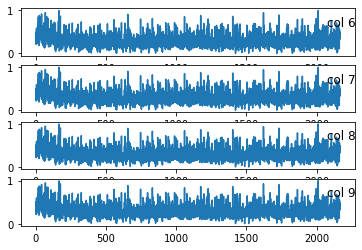

In [207]:
# specify columns to plot
values = input_dataset.values
groups = [5, 6, 7, 8]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(input_dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

In [208]:
features = 300
timestep = 1
n_train = 1500
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1500, 1, 300) (1500,) (668, 1, 300) (668,)


In [209]:
type(train_y.shape)

tuple

In [210]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(90, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['mse'])
print(model.summary())

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_40 (LSTM)               (None, 100)               160400    
_________________________________________________________________
dense_29 (Dense)             (None, 90)                9090      
Total params: 169,490
Trainable params: 169,490
Non-trainable params: 0
_________________________________________________________________
None


In [211]:
history = model.fit(train_X, train_y, epochs=700, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 1500 samples, validate on 668 samples
Epoch 1/700
 - 5s - loss: 4.4401 - mean_squared_error: 2585.6499 - val_loss: 4.3425 - val_mean_squared_error: 2764.0429
Epoch 2/700
 - 0s - loss: 4.2307 - mean_squared_error: 2585.6499 - val_loss: 4.0589 - val_mean_squared_error: 2764.0430
Epoch 3/700
 - 0s - loss: 3.9053 - mean_squared_error: 2585.6500 - val_loss: 3.6862 - val_mean_squared_error: 2764.0429
Epoch 4/700
 - 0s - loss: 3.5548 - mean_squared_error: 2585.6500 - val_loss: 3.3530 - val_mean_squared_error: 2764.0430
Epoch 5/700
 - 0s - loss: 3.2565 - mean_squared_error: 2585.6501 - val_loss: 3.0925 - val_mean_squared_error: 2764.0431
Epoch 6/700
 - 0s - loss: 3.0117 - mean_squared_error: 2585.6501 - val_loss: 2.8775 - val_mean_squared_error: 2764.0432
Epoch 7/700
 - 0s - loss: 2.8083 - mean_squared_error: 2585.6502 - val_loss: 2.6941 - val_mean_squared_error: 2764.0432
Epoch 8/700
 - 0s - loss: 2.6354 - mean_squared_error: 2585.6503 - val_loss: 2.5378 - val_mean_squared_error: 276

In [0]:
results = model.predict(test_X)
#score, acc = model.evaluate(test_X, test_y)

In [0]:
final_results = np.arange(test_y.shape[0])
index = 0
for c in results:
  ind = np.argmax(c)
  final_results[index] = ind 
  index = index + 1;

In [214]:
correct_classification = 0
total_classification = 0
for d, c in zip(final_results, test_y):
  total_classification = total_classification + 1
  if int(d) == int(c):
    correct_classification = correct_classification + 1
print(total_classification, correct_classification)

668 610


In [215]:
score = model.evaluate(test_X, test_y)
print('score:', score)

668/668 [==============================] - 0s 73us/step
score: [0.536954249182861, 2764.0532343516093]


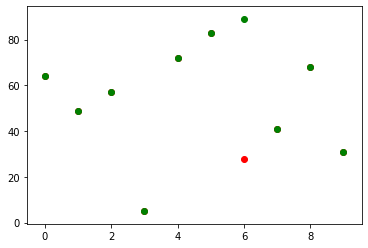

In [216]:
results.shape
plt.scatter(range(10), final_results[:10], c='r');
plt.scatter(range(10), test_y[:10], c='g');
plt.show()

Text(0.5, 0, 'epoch')

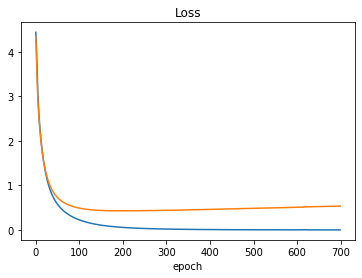

In [217]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')